# Safety first: An analysis of UK major accidents in 2020 to reduce road fatalities

## 📖 BACKGROUND

We work for the road safety team within the department of transport, and the department is looking into how they can reduce the number of serious accidents.

It is important to notice that the safety team classes serious accidents as fatal accidents involving 3+ casualties.

The department is trying to learn more about the characteristics of these accidents, so they can brainstorm interventions that could lower the number of deaths.

They have asked for our assistance with answering a number of questions.

## 💾 THE DATA

We have two sources of information available:
- A dataset containing data on every accident that is reported. 
This dataset has been published by the UK department for transport and it is available [here](https://data.gov.uk/dataset/road-accidents-safety-data).
- A lookup file for 2020's accidents.
This file contains a description of each of accidents' dataset columns and will be useful to correctly interpret the accidents' data.

## 📌 PROBLEM STATEMENT

Our goal for this project is to create a report that answers the following questions:

1. What time of day and day of the week do most serious accidents happen?
2. Are there any patterns in the time of day / day of the week when serious accidents occur?
3. What characteristics stand out in serious accidents compared with other accidents?
4. On what areas would you recommend the planning team focus their brainstorming efforts to reduce serious accidents?

Through data cleaning, analysis and visualization we will answer these questions in order to help our stakeholder to increase road safety by understanding when and how fatal accidents tend to happen and, consequently, take actions to prevent them and save lives.

## 📚 LOAD PACKAGES

Let's start by loading all the necessary Python packages.

In [285]:
# Import necessary libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns 
from matplotlib import rcParams
from datetime import time, timedelta, datetime
from time import mktime
import plotly.graph_objects as go

## 🗓 LOAD DATAFRAMES

We will then load the available datasets. This is how the first dataframe, about the accidents occurred, looks like.

In [286]:
# Accidents dataset
accidents = pd.read_csv(r'./data/accident-data.csv')
accidents.head()

,accident_index,accident_year,accident_reference,longitude,latitude,accident_severity,number_of_vehicles,number_of_casualties,date,day_of_week,...,second_road_class,second_road_number,pedestrian_crossing_human_control,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area
0,2020010219808,2020,10219808,-0.254001,51.462262,3,1,1,04/02/2020,3,...,6,0,9,9,1,9,9,0,0,1
1,2020010220496,2020,10220496,-0.139253,51.470327,3,1,2,27/04/2020,2,...,6,0,0,4,1,1,1,0,0,1
2,2020010228005,2020,10228005,-0.178719,51.529614,3,1,1,01/01/2020,4,...,6,0,0,0,4,1,2,0,0,1
3,2020010228006,2020,10228006,-0.001683,51.541210,2,1,1,01/01/2020,4,...,6,0,0,4,4,1,1,0,0,1
4,2020010228011,2020,10228011,-0.137592,51.515704,3,1,2,01/01/2020,4,...,5,0,0,0,4,1,1,0,0,1


While this is the lookup file with the accidents' fields descriptions.

In [287]:
# Lookup dataset
lookup = pd.read_csv(r'./data/road-safety-lookups.csv')
lookup.head()

,table,field name,code/format,label,note
0,Accident,accident_index,NaN,NaN,unique value for each accident. The accident_i...
1,Accident,accident_year,NaN,NaN,NaN
2,Accident,accident_reference,NaN,NaN,In year id used by the police to reference a c...
3,Accident,longitude,NaN,NaN,Null if not known
4,Accident,Latitude,NaN,NaN,Null if not known


## ⌛️ EXPLORATORY DATA ANALYSIS

To identify effective strategies for increasing road safety and reducing the number of serious accidents, it is important to understand the circumstances. Still, before diving deeper into the analysis, the our available data has to be examined and, if necessary, properly cleaned.

In [288]:
# Quick glimpse at the data
accidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91199 entries, 0 to 91198
Data columns (total 27 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   accident_index                           91199 non-null  object 
 1   accident_year                            91199 non-null  int64  
 2   accident_reference                       91199 non-null  object 
 3   longitude                                91185 non-null  float64
 4   latitude                                 91185 non-null  float64
 5   accident_severity                        91199 non-null  int64  
 6   number_of_vehicles                       91199 non-null  int64  
 7   number_of_casualties                     91199 non-null  int64  
 8   date                                     91199 non-null  object 
 9   day_of_week                              91199 non-null  int64  
 10  time                                     91199

We have a dataframe of 27 columns and more than 91K rows, and almost none of the values is null, except for a few data points in the longitude and latitude columns. Now let's understand if we have duplicates among the accidents. To do this we will use the accidents' unique reference number.

In [289]:
# Check for duplicates
dups = accidents[accidents.duplicated(['accident_index'])]
print(len(dups))

0


There are no duplicates. For this reason, we cay say that there were a total of 91199 recorded road accidents in the UK, but now the question is: what period does our dataset refer to? Let's quickly explore the accident_year column.

In [290]:
# Look into accidents' year
accidents.accident_year.value_counts()

2020    91199
Name: accident_year, dtype: int64

This means that all accidents in our dataset happened during the year 2020. 

Now, we know that the transport department wants to focus on serious accidents. And we also know that a serious accident is considered a fatal accident involving **3+ casualties**. Therefore, for the extent of this analysis, we will focus our work on this specific subset.

In [291]:
# Select only accidents with 3 or more casualties involved
serious = accidents.loc[accidents['number_of_casualties'] >= 3]
serious.head()

# How many serious accidents in 2020?
print(f'In 2020, there were a total of {serious.shape[0]} serious accidents in the UK.')

In 2020, there were a total of 4817 serious accidents in the UK.


### ❓ Question 1: When do most serious accidents happen?

The first question is: What **time of day** and **day of the week** do most serious accidents happen?
Let's investigate and answer this question using the data we have available. In this part we will will explore when fatal accidents are more likely to occur in the UK in 2020.

Let's start by analysing the days of the week. As we can see in the lookup, the days are represented by numbers in our accident dataframe, starting from 1 (Sunday) until 7 (Saturday). We will convert them into strings for more clarity and we will create a bar chart to show the number of accidents that happened on each day of the week.

In [292]:
# Look for information about this column
lookup.loc[lookup['field name'] == 'day_of_week']

,table,field name,code/format,label,note
11,Accident,day_of_week,1,Sunday,NaN
12,Accident,day_of_week,2,Monday,NaN
13,Accident,day_of_week,3,Tuesday,NaN
14,Accident,day_of_week,4,Wednesday,NaN
15,Accident,day_of_week,5,Thursday,NaN
16,Accident,day_of_week,6,Friday,NaN
17,Accident,day_of_week,7,Saturday,NaN


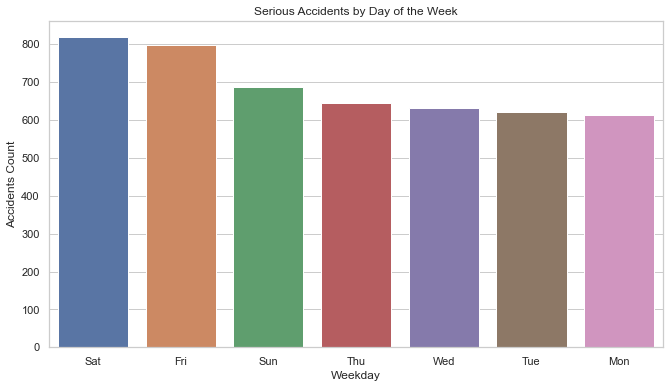

In [293]:
# Replace values
serious['day_of_week'].replace({1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5:'Thu', 6:'Fri', 7:'Sat'}, inplace=True)

# Increase chart size for better readability
sns.set(rc={'figure.figsize':(11,6)})

# Plot serious accidents occurred for each day of the week
sns.set_theme(style="whitegrid")
sns.countplot(x=serious.day_of_week, data=serious, order = serious.day_of_week.value_counts().index)
plt.title('Serious Accidents by Day of the Week')
plt.xlabel('Weekday')
plt.ylabel('Accidents Count')
plt.show()

It seems that serious accidents most likely happen on Saturday, followed by Friday and Sunday. This means that during the weekend the chances are higher for a fatal accident with at least 3 casualties to occur. Let's look at the numbers and do a little sanity check to confirm this assumption.

In [294]:
# Find the mode, which is the value that appears most often
serious.day_of_week.mode()

0    Sat
dtype: object

In [295]:
# Sort weekdays by number of accidents occurred
serious.day_of_week.value_counts()

Sat    820
Fri    798
Sun    687
Thu    645
Wed    632
Tue    621
Mon    614
Name: day_of_week, dtype: int64

In [296]:
# Calculate percentages
serious_accidents_total = serious.shape[0]
percent_missing = serious.day_of_week.value_counts() * 100 / serious_accidents_total
print(percent_missing.round(2))

Sat    17.02
Fri    16.57
Sun    14.26
Thu    13.39
Wed    13.12
Tue    12.89
Mon    12.75
Name: day_of_week, dtype: float64


Indeed, we can confirm that the top day of the week with most accidents recorded is **Saturday**, with 17% of serious accidents happening on this day of the week.

We can also say that during 2020 most serious accidents happened during the weekend, being the following the top days:
1. **Saturday**: 820 fatal accidents (17%)
2. **Friday**: 798 fatal accidents (16,6%)
3. **Sunday**: 687 fatal accidents (14,3%)

Which, in total, account for the 47,8% of serious accidents.

The safest day to be on the road is Monday, instead.

Now we will look into the time of the day that records the highest number of serious accidents.

As we have seen above when glimpsing at the dataframe, the time column is an object datatype, and we should convert it into a more suitable type like a datetime in order to easily manipulate it.

In [297]:
# Cast time column into datetime
serious['time'] = serious['time'].apply(lambda x: datetime.strptime(x, '%H:%M'))

# Extract hour and minutes from the datetime
serious['hour'] = serious['time'].dt.time

# Check
serious['hour'].head()

11     03:40:00
136    22:45:00
173    11:20:00
187    14:33:00
212    15:50:00
Name: hour, dtype: object

Now that we extracted the exact time of each serious accident, we will bin the time of day and categorize accidents according to when they occurred. We will create 4 periods, more specifically:
- **Night** (from 12 am to 5.59 am)
- **Morning** (from 6 am to 11.59 am)
- **Afternoon** (from 12 pm to 5.59 pm)
- **Evening** (from 6 pm to 11.59 pm)

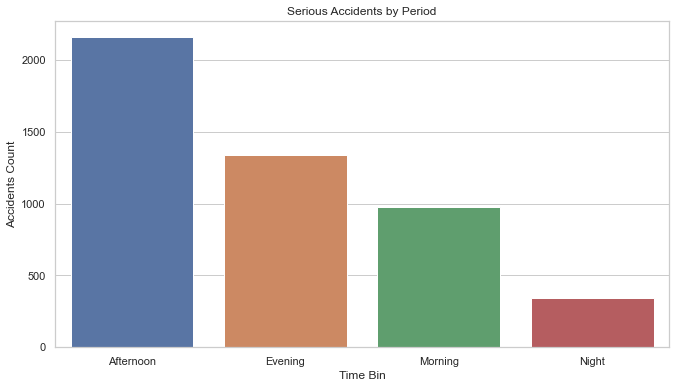

In [298]:
# Create hour bins and add respective labels
bins = [0, 6, 12, 18, 24]
labels = ['Night', 'Morning', 'Afternoon', 'Evening']
serious['timebin'] = pd.cut(serious['time'].dt.hour, bins, labels = labels, right = False)

# Plot values
sns.countplot(x = serious.timebin, data = serious, order = serious.timebin.value_counts().index)
plt.title('Serious Accidents by Period')
plt.xlabel('Time Bin')
plt.ylabel('Accidents Count')
plt.show()

In [299]:
# Sort values
serious.timebin.value_counts()

Afternoon    2164
Evening      1336
Morning       974
Night         343
Name: timebin, dtype: int64

In [300]:
# Calculate percentages
percent_missing = serious.timebin.value_counts() * 100 / serious_accidents_total
print(percent_missing.round(2))

Afternoon    44.92
Evening      27.74
Morning      20.22
Night         7.12
Name: timebin, dtype: float64


The majority of serious accidents happened during the **afternoon** period, i.e. in the hour range that goes from 12pm until 5.59pm. This bin accounts for almost **45%** of the accidents.

The second bin with more accidents is the evening, followed by the morning and lastly the night bin.

Now we want to go into detail and know the exact hour in which most serious accidents occur. So we will create more specific bins, one for each hour, and plot the result in a bar chart.

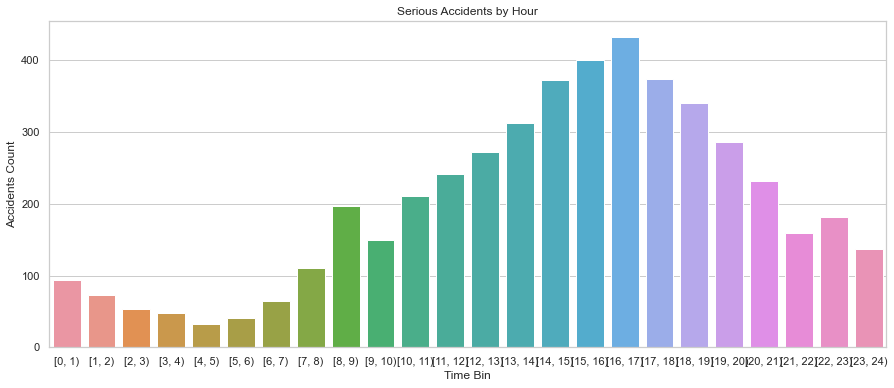

In [301]:
# Create hour bins
bins = list(range(0, 25))
serious['bin_hours'] = pd.cut(serious['time'].dt.hour, bins, right = False)

# Increase size for better clarity
sns.set(rc = {'figure.figsize':(15,6)})

# Plot values
sns.set_theme(style="whitegrid")
sns.countplot(x = serious.bin_hours, data = serious)
plt.title('Serious Accidents by Hour')
plt.xlabel('Time Bin')
plt.ylabel('Accidents Count')
plt.show()

In [302]:
# Sort values
serious['bin_hours'].value_counts().head()

[16, 17)    433
[15, 16)    401
[17, 18)    374
[14, 15)    372
[18, 19)    341
Name: bin_hours, dtype: int64

The hour range in which most serious accidents occur is the time frame **between 4 pm and 4.59 pm**. As we can see, in general the top hours with most serious accidents are the afternoon hours, from 2 pm until 7 pm. This outcome is coherent with what we found in the previous analysis.

Now we will cross days of week and time to see if we can find additional insights. Let's consider weekend days, as it is the period with more serious accidents, and weekdays (Monday-Thursday) separately, and cross these periods with the time bins.

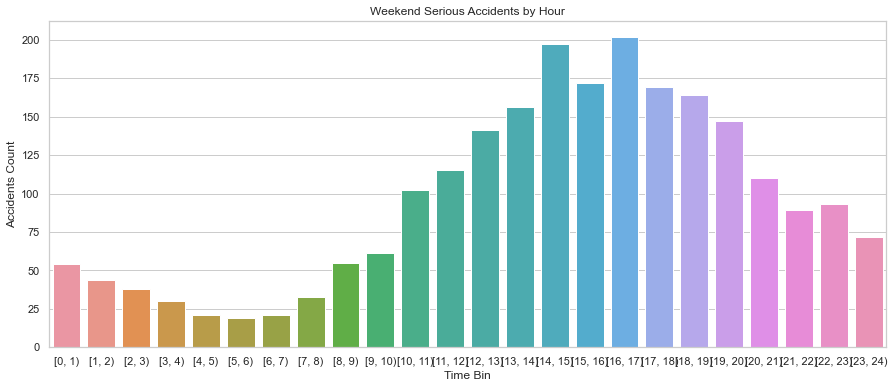

In [303]:
# Select just weekends' data subset
weekend = ['Sat', 'Fri', 'Sun']
time_wknd = serious[serious['day_of_week'].isin(weekend)]

# Create hour bins
bins = list(range(0, 25))
time_wknd['bin_hours'] = pd.cut(time_wknd['time'].dt.hour, bins, right=False)
time_wknd['bin_hours'] = time_wknd['bin_hours']

# Increase size for better clarity
sns.set(rc = {'figure.figsize':(15,6)})

# Plot values
sns.set_theme(style="whitegrid")
sns.countplot(x = time_wknd['bin_hours'], data = time_wknd)
plt.title('Weekend Serious Accidents by Hour')
plt.xlabel('Time Bin')
plt.ylabel('Accidents Count')
plt.show()

In [304]:
# Sort values
time_wknd['bin_hours'].value_counts().head()

[16, 17)    202
[14, 15)    197
[15, 16)    172
[17, 18)    169
[18, 19)    164
Name: bin_hours, dtype: int64

During the weekend the most dangerous hours, i.e. the hours with most serious accidents are, again, the afternoon hours in the range from 2 pm to 7 pm. This reflects the general distribution of accidents by time (without taking into account the separation of weekend days from the remaining weekdays).

In the next step we will consider only the interval between Monday and Thursday to see if there are differences in the number of accidents by time compared to the weekend.

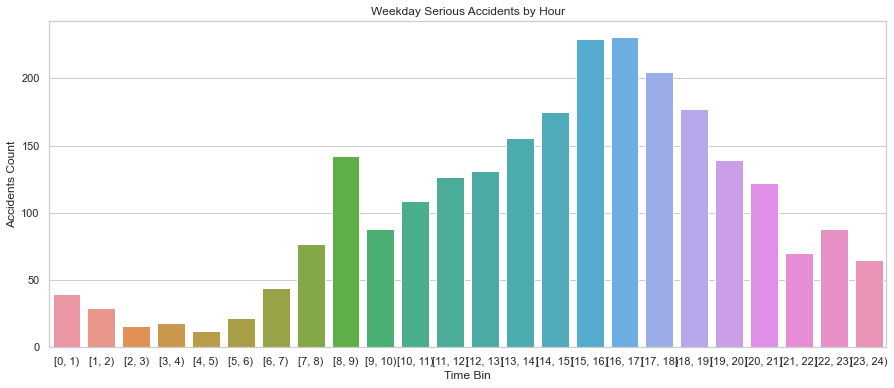

In [305]:
# Select just weekdays' data subset
weekdays = ['Mon', 'Tue', 'Wed', 'Thu']
time_weekday = serious[serious['day_of_week'].isin(weekdays)]

# Create hour bins
bins = list(range(0, 25))
time_weekday['bin_hours'] = pd.cut(time_weekday['time'].dt.hour, bins, right=False)
time_weekday['bin_hours'] = time_weekday['bin_hours']

# Increase size for better clarity
sns.set(rc = {'figure.figsize':(15,6)})

# Plot values
sns.set_theme(style="whitegrid")
sns.countplot(x = time_weekday['bin_hours'], data = time_weekday)
plt.title('Weekday Serious Accidents by Hour')
plt.xlabel('Time Bin')
plt.ylabel('Accidents Count')
plt.show()

In [306]:
# Sort values
time_weekday['bin_hours'].value_counts().head()

[16, 17)    231
[15, 16)    229
[17, 18)    205
[18, 19)    177
[14, 15)    175
Name: bin_hours, dtype: int64

In this case, too, the most dangerous hours are the afternoon hours from 2 pm to 7 pm. Still, the distribution is slightly different compared to that of weekend days, as we can see an increase of accidents in the time bin from 8 am to 9 am here. 

How can we explain this? This is probably due to the fact that, during the week, in the morning many people drive to go to work.

Now let's extract the month of when each fatal accident happened during 2020, as this information can be useful in brainstorming whether major accidents tend to happen more frequently in specific times of the year. Again, we will plot the values in a bar plot to have the general picture.

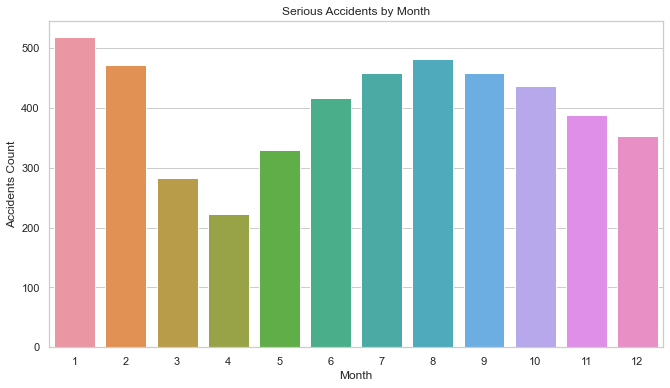

In [307]:
# Cast date column from object into datetime
serious['date'] = pd.to_datetime(serious['date'])

# Extract just the month number from the datetime
serious['month'] = serious['date'].dt.month

# Set size for better clarity
sns.set(rc = {'figure.figsize':(11,6)})

# Plot values
sns.set_theme(style="whitegrid")
sns.countplot(x = serious.month, data = serious)
plt.title('Serious Accidents by Month')
plt.xlabel('Month')
plt.ylabel('Accidents Count')
plt.show()

In [308]:
# Sort values
serious['month'].value_counts()

1     519
8     481
2     471
9     459
7     458
10    437
6     417
11    388
12    353
5     329
3     283
4     222
Name: month, dtype: int64

In [309]:
# Calculate percentages
percent_missing = serious.month.value_counts() * 100 / serious_accidents_total
print(percent_missing.round(2))

1     10.77
8      9.99
2      9.78
9      9.53
7      9.51
10     9.07
6      8.66
11     8.05
12     7.33
5      6.83
3      5.88
4      4.61
Name: month, dtype: float64


The data tells us that most serious accidents happened during the month of **January**, followed by August and then February. The "less dangerous" month in which to drive is April, instead.

At this point we can cross months and days of the week data to see if we can find additional insights.

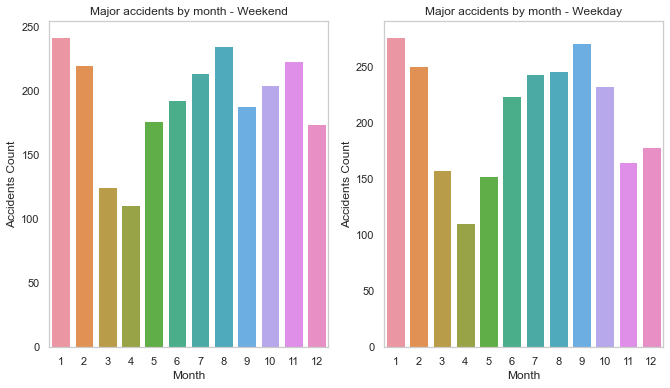

In [310]:
# Select just weekends' data subset
weekend = ['Sat', 'Fri', 'Sun']
time_wknd = serious[serious['day_of_week'].isin(weekend)]

# Select just weekdays' data subset
time_weekday = serious[~serious['day_of_week'].isin(weekend)]

# Create two bar plots
fig, axes = plt.subplots(1,2)
sns.set_theme(style="whitegrid")

sns.countplot(x = time_wknd['month'], data = time_wknd, ax = axes[0])
axes[0].set(xlabel = 'Month', ylabel ='Accidents Count', title = 'Major accidents by month - Weekend')
axes[0].grid(axis = 'y')

sns.countplot(x = time_weekday['month'], data = time_weekday, ax = axes[1])
axes[1].set(xlabel = 'Month', ylabel = 'Accidents Count', title = 'Major accidents by month - Weekday')
axes[1].grid(axis = 'y')

plt.show()

When analyzing the month vs. day of the week, there are some differences according to whether we are considering the weekend days or the weekdays. The main variations are spotted in the months of May, September and November.

During the weekends of May there are more accidents than on the weekdays and the same happens in November. While in September there are more accidents in the weekdays compared to the weekends.

### 🖌 Answer 1

To sum up our analysis findings, according to the data available we can state the following conclusions about the accidents with 3 or more casualties occurred in 2020 in the UK:

- Generally speaking, most serious accidents happened on **Saturday** (17%). The 2nd and 3rd days with most serious accidents are Friday (16,6%) and Sunday (14,3%), so the **weekend** seems the most dangerous time to be on the road as these 3 days only account for near the half, **47,8%**, of serious accidents. The safest day to be on the road is Monday, instead, with a 12.7% of serious accidents.

- Considering the following periods:
    - Night (from 12 am to 5.59 am)
    - Morning (from 6 am to 11.59 am)
    - Afternoon (from 12 pm to 5.59 pm)
    - Evening (from 6 om to 11.59 pm)



- Most serious accidents happened during the **afternoon** period. This bin accounts for almost **45%** of the accidents and it is followed by evening (27,7%), morning (20,2%) and night (7,1%). More specifically, serious accidents occur more frequently in the time frame **between 4 pm and 5 pm**.

- When comparing the weekdays (Monday to Thursday) versus the weekend days (Friday to Sunday) the distribution of accidents over the hours is similar, with the afternoon hours from 2 pm to 7 pm being the most dangerous ones to be on the road.

- However, when analysing the **weekdays**, we have observed a rise in the accidents count happening **from 8 am to 9 am** compared to the weekend days. This is probably due to the fact that the weekdays' morning hours are a common time for commuting i.e. many people drive to go to their workplace.

- Most serious accidents (10,8%) happened in **January**, followed by the months of August and February. The safest month to be on the road is April, instead, accounting for just 4,6% of the accidents.

- Lastly, when comparing the months versus the days of the week we observed some differences, too. More specifically, during the weekends of May there are more accidents than on the weekdays and the same happens in November. While in September there are more accidents in the weekdays than in the weekends.

### ❓ Question 2: Are there any patterns?

The second question is: Are there any **patterns** in the time of day / day of the week when serious accidents occur? We already have gathered some useful insights to address this question, but we will investigate further to find out whether we can extract additional information.

What we are going to do is to cross-reference the available data regarding the days of the week and the time of day, build a heat map using this data and see if there are any critical points or trends.

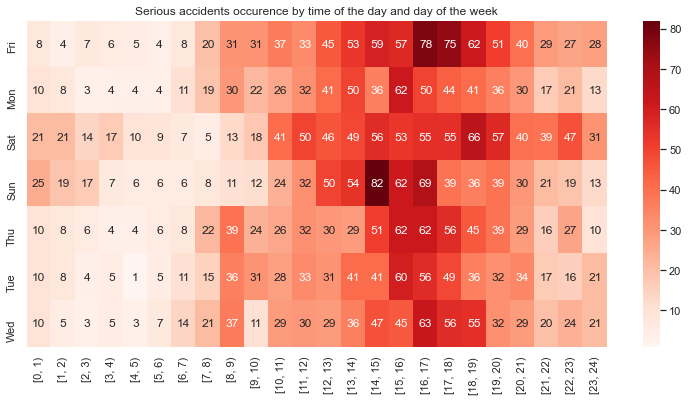

In [311]:
# Cross the day of the week and hours
cross_data = pd.crosstab(serious.day_of_week, serious.bin_hours)

# Plot the heat map
fig, ax = plt.subplots(figsize = (13,6))
sns.heatmap(cross_data, cmap = "Reds", annot = True, ax = ax)
plt.xlabel("")
plt.ylabel("")
plt.title("Serious accidents occurence by time of the day and day of the week")
plt.show()

### 🖌 Answer 2

Looking at the table we can spot various patterns:

- Generally speaking, the **night and early morning** hours between 12 am and 7 pm tend to be the period with **less serious accidents** during all days of the week.

- Still, there is an accidents' increase during the **nights** between **Friday and Saturday**, and also **Saturday and Sunday**. The accidents number is **more than double** that of the other days. This is probably due to the fact that more people go out late at night knowing that they do not have to work the next morning, as traditionally on weekends people of various categories (like office workers) do not work.

- Moving on during the course of the day, we can see that accidents start to increase in the **morning**. But again, we observe different patterns if we compare Monday to Friday with Saturday and Sunday.

- **During the week** (Mon - Fri) the increase starts from **7 am**, and we can see a significant **rise** in the number of accidents around **8-9 am**, that may be due to commuting to work. Then we observe a slight decrease until we reach the late morning / early noon hours (from 11 am). 

- We can see a different pattern on **Saturday and Sunday**. Indeed, during these days the number of accidents starts to rise later in the day, from **10 - 11 am** onwards, and the number is **more than double** compared to the previous time frame (9 - 10 am). As we said before, during these days traditionally people do not work (meaning they don't have to commute).

- Starting from the afternoon hours, from 12 - 1 pm, the difference between Mon-Fri and weekend days is lower. **Afternoons** are a **critical time** regardless of the day of the week.

- During the **evening**, serious accidents gradually decrease until they reach a minimum at night time. Still, **Saturday** numbers remain higher until midnight. Friday ones, to a lesser extent, too.  This is not quite surprising as some people might drink and drive home after dinners and/or other social gatherings.

### ❓ Question 3: Features of serious vs. other accidents

The third question is: What **characteristics** stand out in **serious accidents** compared with other accidents? We will focus mainly on analysing serious accidents separately from other accidents and then compare the results obtained to look for similarities or differences.

First of all, we will perform some data cleaning. Moreover, although when we initially looked at the accidents' dataframe it seemed that there were hardly any null values, when we analysed in-depth the lookup file we found that, for some columns, the unknown data is indicated with the value -1, 9 or 99
*(note: this does not affect the analysis done so far as in the day of week and date columns there were no unknown values)*.

So, before proceeding to the actual analysis, we need to clean and count the percentage of the unknown values in relation to the total and decide whether we should remove or treat them in some way.

In [312]:
# Remove non-relevant columns
drop_list = ['accident_index', 'accident_year', 'accident_reference', 'date',
             'first_road_number', 'second_road_number']
accidents = accidents.drop(columns = drop_list)

In [313]:
# Replace -1 with null
accidents = accidents.replace(-1, np.nan)

# Replace unknown data, marked with 99 or 9, with null
accidents['speed_limit'] = accidents['speed_limit'].replace(99, np.nan)
accidents['junction_detail'] = accidents['junction_detail'].replace(99, np.nan)
 
accidents['road_type'] = accidents['road_type'].replace(9, np.nan)
accidents['pedestrian_crossing_human_control'] = accidents['pedestrian_crossing_human_control'].replace(9, np.nan)
accidents['pedestrian_crossing_physical_facilities'] = accidents['pedestrian_crossing_physical_facilities'].replace(9, np.nan)
accidents['weather_conditions'] = accidents['weather_conditions'].replace(9, np.nan)
accidents['road_surface_conditions'] = accidents['road_surface_conditions'].replace(9, np.nan)
accidents['special_conditions_at_site'] = accidents['special_conditions_at_site'].replace(9, np.nan)
accidents['carriageway_hazards'] = accidents['carriageway_hazards'].replace(9, np.nan)

# Calculate unknown values
percent_missing = accidents.isnull().sum() * 100 / len(accidents)
percent_missing

longitude                                   0.015351
latitude                                    0.015351
accident_severity                           0.000000
number_of_vehicles                          0.000000
number_of_casualties                        0.000000
day_of_week                                 0.000000
time                                        0.000000
first_road_class                            0.000000
road_type                                   2.199586
speed_limit                                 0.013158
junction_detail                             1.655720
junction_control                           41.993882
second_road_class                           0.000000
pedestrian_crossing_human_control           3.810349
pedestrian_crossing_physical_facilities     3.362975
light_conditions                            0.001097
weather_conditions                          2.657924
road_surface_conditions                     1.275233
special_conditions_at_site                  1.

As we can see, the column junction control's null values account for 42% of the values. They are a lot so we will drop the column as it cannot give enough relevant information. All the other columns present a low percentage of null values. We will drop those values.

In [314]:
# Remove junction control column
accidents = accidents.drop('junction_control', axis = 1)
                           
# Remove null values
accidents = accidents.dropna()

Now we can analyse the data comparing serious accidents and other accidents. We will analyse how each feature performs according to the accidents severity, in terms of percentage, for better clarity.

In [315]:
# Divide serious from other accidents and create new boolean column
serious = (accidents['number_of_casualties'] >= 3)
accidents['serious'] = np.where(serious, 'Yes', 'No')

# Create function to calculate percentage of values and plot the results
def plot_features(column):
    table_perc = accidents.groupby('serious')[column].value_counts(normalize = True, sort = False) * 100
    table_perc = table_perc.reset_index(name="percentage")
    
    sns.barplot(x = column, y = 'percentage', hue = 'serious', data = table_perc, palette = 'hls')
    labels = [i for i in range(0,105,5)]
    plt.yticks(labels)
    plt.ylabel('Accidents Percentage')
    return plt.show()

We will start to analyze the road type column and plot the result.

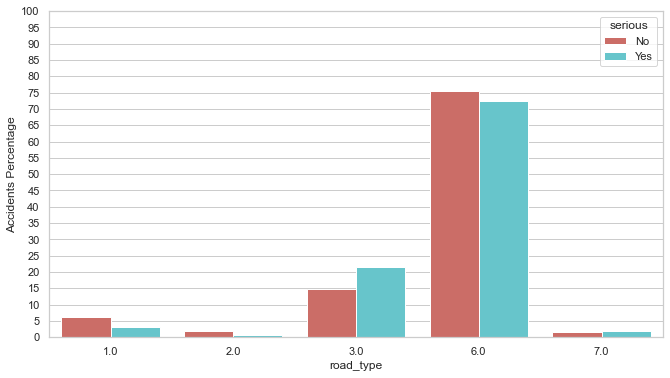

In [316]:
plot_features('road_type')

Knowing that this is the legend for the road type column:
- 1: Roundabout
- 2: One way street
- 3: Dual carriageway
- 6: Single carriageway
- 7: Slip road

We can affirm that the data distribution is similar. **Both most serious and other accidents** mostly happened in **single carriageways**. A single carriageway is a road with one, two or more lanes arranged without a central reservation to separate opposing flows of traffic, so this data is not surprising. Another similarity is that slip road are the least cause of both serious and non-serious accidents.

The differences are in the percentages. There are more non-serious accidents in roundabouts, single carriages and one way streets. While there are more serious accidents in dual carriageways compared to non-serious ones on the same type of road.

Now we will analyse the junction details.

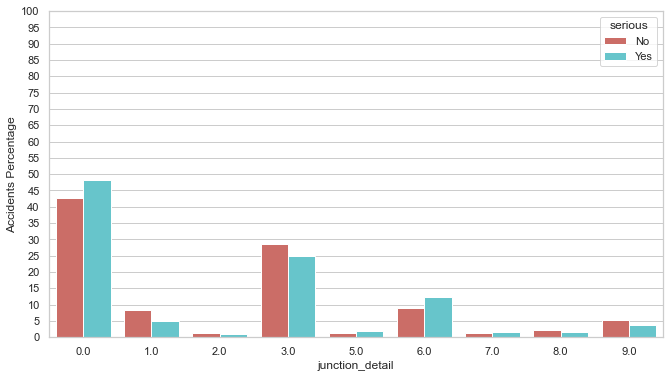

In [317]:
plot_features('junction_detail')

Legend:

- 0: Not at junction or within 20 metres
- 1: Roundabout
- 2: Mini-roundabout
- 3: T or staggered junction
- 5: Slip road
- 6: Crossroads
- 7: More than 4 arms (not roundabout)
- 8: Private drive or entrance
- 9: Other junction

In this case the two distributions are similar if we compare serious and non-serious accidents. In both cases, most accidents did not happen at junctions, or within 20 mt. from one.

Also, in both cases most accidents happened at a T or staggered junction (i.e. a place where several roads meet a main road at a slight distance apart, so that they do not all come together at the same point). The second most dangerous category are crossroads.

Differences: in the case of T or staggered junction non-serious accidents are more, while in the case of crossroads we can observe more serious accidents.

The next feature to be analysed is related to the pedestrian crossing.

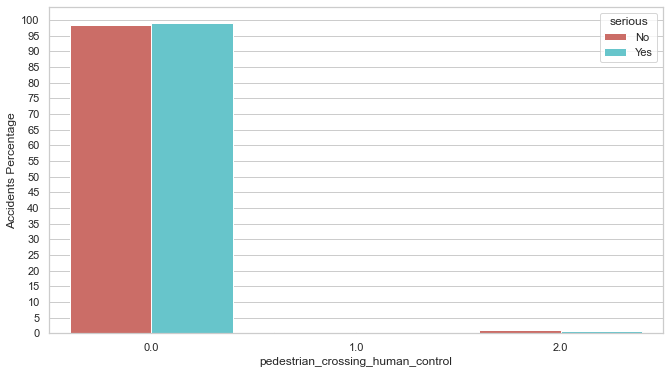

In [318]:
plot_features('pedestrian_crossing_human_control')

Legend:
- 0: No control within 50 metres
- 1: Control by school crossing patrol
- 2: Control by other authorised person

Regarding this column, the plot is quite self explanatory. Almost 100% of both serious and other accidents happened in absence of human control at a pedestrian crossing.

The next feature to be analysed is whether there are physical facilities at a pedestrian crossing or not.

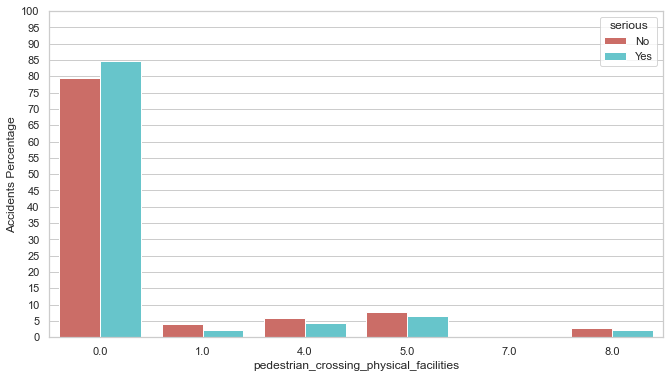

In [319]:
plot_features('pedestrian_crossing_physical_facilities')

Legend:

- 0: No physical crossing facilities within 50 metres
- 1: Zebra
- 4: Pelican, puffin, toucan or similar non-junction facilities
- 5: Pedestrian phase at traffic signal junction
- 7: Footbridge or subway
- 8: Central refuge

Again the distribution is similar for both classes of accidents. Most accidents happened when there are no crossing facilities, but in the case of non-serious ones the percentage is almost 80%, while for the serious ones it is ~85%.

We will now proceed to to analyse the light conditions that existed at the time of the recorded incidents.

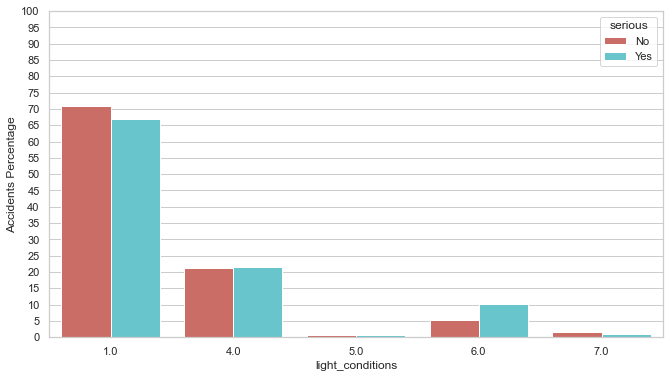

In [320]:
plot_features('light_conditions')

Legend:

- 1: Daylight
- 4: Darkness - lights lit
- 5: Darkness - lights unlit
- 6: Darkness - no lighting
- 7: Darkness - lighting unknown

We can observe that most accidents (approx. 70% of non-serious ones and slightly more than 65% of serious ones) happened when there was daylight. The second most dangerous situation is in the dark with the lights on (20% in both cases).

There is a difference when it comes to situations with no lighting. In these cases the percentage of serious accidents is higher (10% compared to 5% approximately).

The next feature to be analysed are the weather conditions.

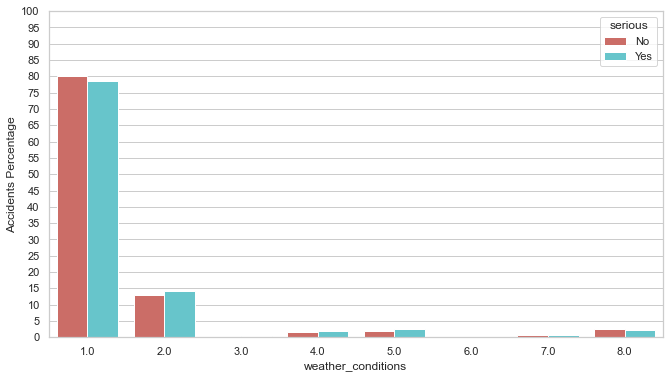

In [321]:
plot_features('weather_conditions')

Legend:

- 1: Fine no high winds
- 2: Raining no high winds
- 3: Snowing no high winds
- 4: Fine + high winds
- 5: Raining + high winds
- 6: Snowing + high winds
- 7: Fog or mist
- 8: Other

One might expect most accidents, especially serious ones, to occur in bad weather conditions. However, this is not the case, as they did occur (80% or almost) in fine conditions with no strong winds.

In the next part we will analyse the conditions of the road surface.

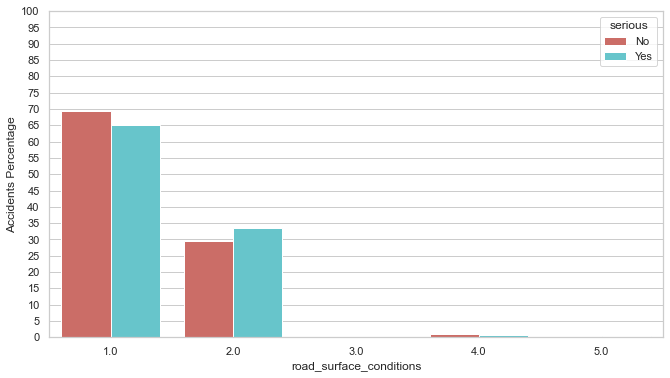

In [322]:
plot_features('road_surface_conditions')

Legend:

- 1: Dry
- 2: Wet or damp
- 3: Snow
- 4: Frost or ice
- 5: Flood over 3cm

Most accidents happened when the road surface was dry. As a difference, there is a higher percentage of serious accidents versus non-serious ones when the road surface is wet or damp. While there is a higher proportion of non-serious accidents when the road surface was dry.

The next feature to be analysed are the special conditions at the site of the accident.

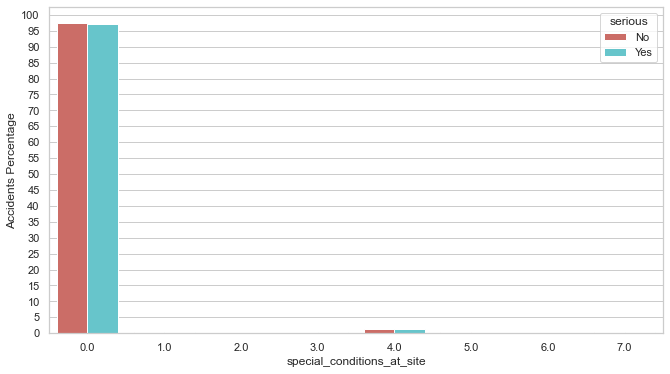

In [323]:
plot_features('special_conditions_at_site')

Legend:

- 0: None
- 1: Auto traffic signal - out
- 2: Auto signal part defective
- 3: Road sign or marking defective or obscured
- 4: Roadworks
- 5: Road surface defective
- 6: Oil or diesel
- 7: Mud

This bar chart is quite self explanatory. Almost 100% of both serious and other accidents happened without any special condition.

The next feature to be analysed is whether there are carriageway hazards or not.

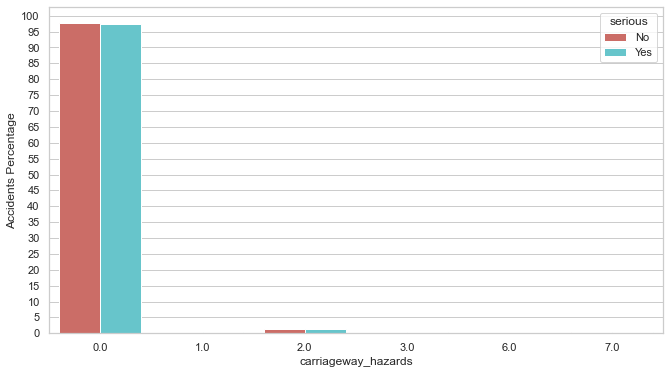

In [324]:
plot_features('carriageway_hazards')

Legend:

- 0:	None
- 1:	Vehicle load on road
- 2:	Other object on road
- 3:	Previous accident
- 4:	Dog on road
- 5:	Other animal on road
- 6:	Pedestrian in carriageway - not injured
- 7:	Any animal in carriageway (except ridden horse)

We do not observe relevant differences between the occurence of serious and non-serious accidents when it comes to carriageway hazards. Almost 100% of then appened in normal circumstances (no hazards).

Now we will analyze the location of the accidents, whether it was an urban or rural area.

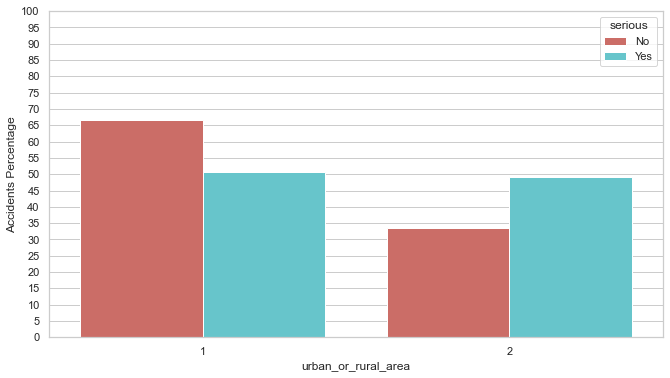

In [325]:
plot_features('urban_or_rural_area')

Legend: 
- 1: Urban
- 2: Rural

This time we can observe quite opposite tendencies. In fact, serious accidents are likely to happen in rural areas, whereas urban areas are the setting of most non-serious accidents.

The next feature to analyze is the speed limit.

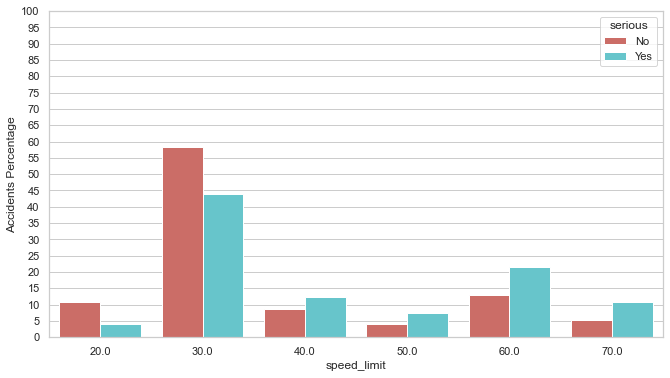

In [326]:
plot_features('speed_limit')

Again we can see similarities and differences. In both categories, most accidents occur in streets with a speed limit of 30 miles per hour (48km/h). In non serious accidents we observe more accidents with a lower speed limit, 20 mph, versus serious ones. While serious accidents tend to happen on roads with higher speed limits (starting from 40mph) than non-serious ones.

Lastly, we will look into the number of vehicles involved.

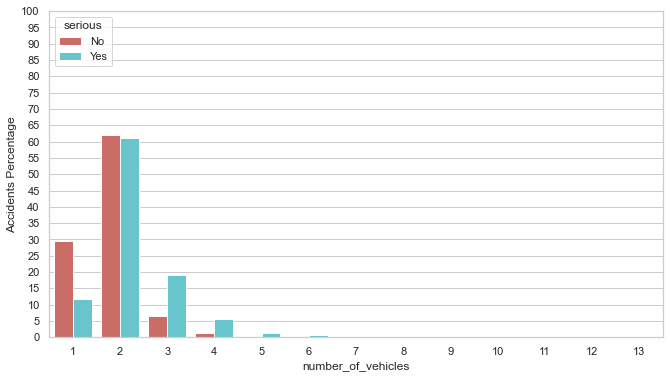

In [327]:
plot_features('number_of_vehicles')

As we can see, there is a higher proportion of serious accidents (almost 20%) when the number of vehicles is equal or greather than 3. By contrast, a higher proportion of non-serious accidents (almost 30%) happened when the vehicle was just one.

### 🖌 Answer 3

In this part of the report the aim was to find out which characteristics distinguish serious accidents over non-serious ones.

We discovered various insights which we will summarise below.

- Most incidents (more than 70%), both serious and non-serious, happened at single carriageway roads, i.e. a road with one, two or more lanes arranged without a central reservation to separate opposing flows of traffic. While the lowest percentage of accidents, both serious and non-serious, occurred in one way streets and slip roads. However, we can observe some differences, too. A **higher proportion of serious accidents** happened in **dual carriageway roads** than that of non-serious ones (more than 20% vs ~15%). On the contrary, non-serious accidents are relatively more frequent in roundabouts, single carriages and one way streets.

- Most incidents (more than 40%), both serious and non-serious, did not happen at a junction or within 20 mt. from one. As for the rest, most accidents (between 25 and 30%) happened at a T or staggered junction (i.e. a place where several roads meet a main road at a slight distance apart). The next most dangerous junction category are crossroads which account for around 10% of both serious and non-serious accidents. Differences: **serious accidents are less frequent** in the case of **T or staggered junction** compared to non-serious ones. While in the case of **crossroads**, we can observe **more serious accidents** vs. non-serious.

- Most proportions of serious and non-serious incidents (amost 100% in both cases) happened in roads with absence of human control for pedestrian crossing.

- Most accidents of both classes happened at a **pedestrian crossing without physical facilities**, but in the case of **serious** ones the percentage is **slightly higher** (almost 85%), as for non-serious ones it is a little less than 80%.

- We can also observe that most accidents happened under **daylight**, but in the case of **serious** ones the percentage is **slightly lower** (around 65%), while in the case of non-serious ones is a little higher, ~70%. There also is a difference when it comes to situations of **darkness with no lighting**, as in these cases the percentage of **serious accidents is higher** than non-serious ones.

- As per weather conditions, one might expect most accidents - especially serious ones - to occur in bad weather conditions. However, this is not the case, as almost 80% of them occurred in fine conditions with no strong winds and almost 15% when raining with no strong winds. The proportions are the same for non-serious incidents, even though in case of **rain, serious accidents are slightly more frequent**.

- There is a **higher percentage** (almost 35%) of **serious incidents**, compared to non-serious ones (almost 30%), when the **road surface is wet or damp**. By contrast, a higher proportion of non-serious accidents (~70% versus ~65% of non-serious ones) happened when the road surface was dry.

- **Serious incidents are more likely** to happen on roads with **higher speed limits** - from 40 miles per hour onwards - than non-serious ones, which occurred more frequently on roads with a speed limit of 30 miles per hour.

- Regarding the ares, **serious accidents** tend to happen **more frequently in rural settings**, whereas urban areas are where most non-serious accidents occurred.

- There is no significant difference between the occurence of serious and non-serious accidents when it comes to carriageway hazards (such as objects or animals on the road) or special conditions at the site of the accident (such as defective/obscured road signs, roadworks or oil/diesel on the road surface).

- There is a **higher proportion of serious accidents** (almost 20% vs ~5% of non-serious ones) when the **number of vehicles** involved is equal or greather than **three**. By contrast, a higher proportion of non-serious accidents (almost 30% vs 10%) happened when the vehicle was just one.

### ❓ Question 4: Focus areas

The fourth question is: On what areas would you recommend the planning team focus their brainstorming efforts to reduce serious accidents? 

To answer this question, we will create a map of the UK using the supplied latitudes and longitudes and plot the serious accidents occurred in 2020 to see which areas have a higher density of incidents.

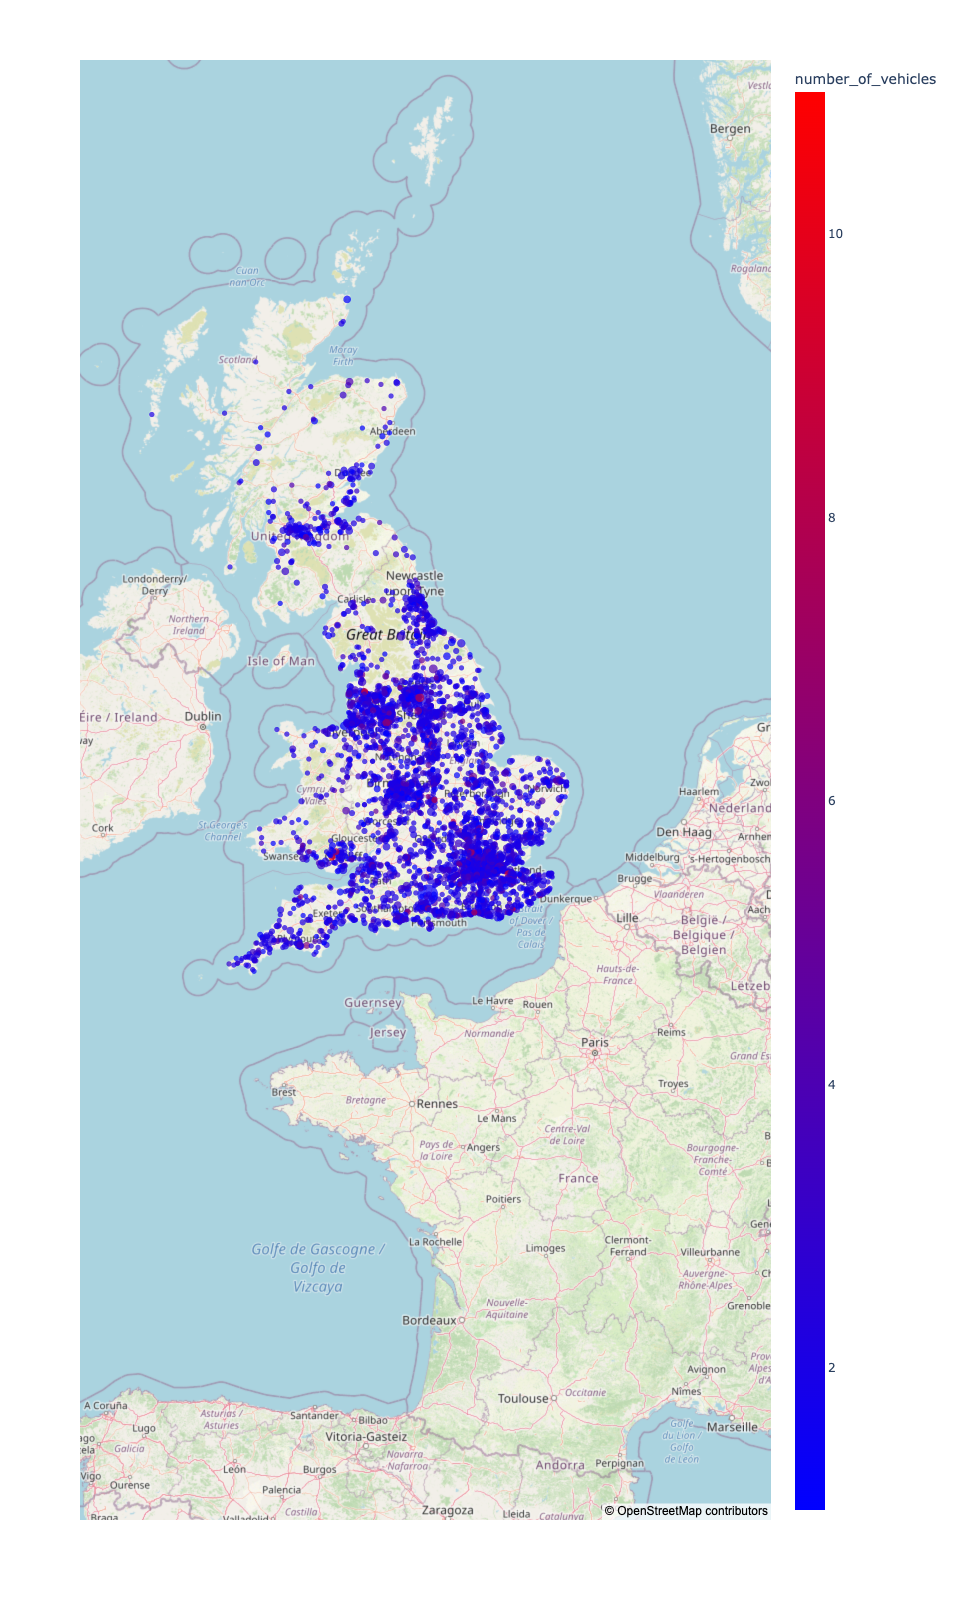

In [328]:
serious = accidents.loc[accidents['number_of_casualties'] >= 3]

# Create scatter plot
fig = px.scatter_mapbox(serious, lat = 'latitude', lon = 'longitude', color = 'number_of_vehicles',
                        size = 'number_of_casualties', color_continuous_scale = px.colors.sequential.Bluered,
                        size_max = 15, zoom = 5, height = 800)

fig.update_layout(mapbox_style = 'open-street-map')
fig.show()

### 🖌 Answer 4

The map above suggests particular aggregations of serious accidents in the following geographical areas:
- Glasgow
- Newcastle upon Tyne
- Leeds
- Liverpool
- Manchester
- Birmingham
- London

We can observe that the **southern** part of the country, **England, more specifically South East, South West and London areas, is most affected** by serious accidents. While Scotland and Wales do not show a high occurrence of serious accidents, except for very specific areas.

We have to say that this distribution probably reflects the population density of each area. In fact, of the countries which make up the UK, England is the most densely populated at 432 people per square kilometer. Scotland, by contrast, is the most sparsely populated one, with only 67 people per square kilometer (*source: [Wikipedia](https://en.wikipedia.org/wiki/Demography_of_Scotland)*).

## 💡 CONCLUSIONS

Based on the results of the above analysis, this section aims to summarise all the observations collected, and gather recommendations for the road safety team in order to reduce the number of serious accidents.

Firstly, since serious accidents are more likely to occur during the weekend, it may be useful to plan the launch of a **weekend-running communication campaign** to raise awareness of this issue and inform the drivers to adopt preventive measures, such as not driving after drinking alcohol.

We have observed that the afternoon is generally a critical time of the day for serious accidents. During the weekends the most dangerous time are the nights between Friday and Saturday and Saturday and Sunday. Also, during the weekdays there is a rise in the serious accidents count happening from 8 am to 9 am. Therefore it may be useful to have **more police and patrols available** during these specific periods.

When possible, a **traffic separation area between opposite lanes** should be added for single carriageways, as they are the cause of most accidents. 

**Junctions** may be another measure to reduce the number of accidents. Even though T or staggered junction have proven to be the cause of 25/30% of accidents so other types of junctions should be preferred.

More **pedestrian crossing facilities** and/or **human controls** will be desirable to prevent accidents from harming pedestrians and not only.

**Improving the road illumination** may contribute to reduce serious accidents, especially those happening during night time with no artificial lighting, because we have observed that in these cases the percentage of serious accidents is higher than non-serious ones.

In case of rain, serious accidents are slightly more frequent. Therefore, roads that can become slippery should be improved and equipped with **waterproof materials**. If there is a lot of water, this causes a loss of friction (hydroplaning), and it can be very dangerous for drivers as they risk to loose control of their vehicle.

Serious incidents are more likely to happen on roads with higher speed limits - from 40 miles per hour onwards. So, it may be worth to place signs that clearly indicate where drivers can switch lanes, or investigate the conditions of road lanes to see if they are suitable for being high-speed roads.

**Rural areas** should be equipped with **better facilities** such as more street lighthing, clearly visible road signs and barriers.

### Thank you for reading this report.

*© Giulia Brambilla, November 2021*